# **-----------ZERO-SHOT-----------**

# **Evaluating the "SamLowe/roberta-base-go_emotions" model**

**1.Initialize**

In [ ]:
!pip install -q transformers accelerate torch datasets scikit-learn pandas

**2.Upload model and tokenizer**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

model_id="SamLowe/roberta-base-go_emotions"
device=0 if torch.cuda.is_available() else -1
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

pipeline = TextClassificationPipeline(
      model=model,
      tokenizer=tokenizer,
      top_k=None, #what is mean? Return all tags
      device=device,
      function_to_apply='sigmoid', #what is mean?
      truncation=True #What is mean?
    )

label = model.config.id2label
labels = [label[i] for i in range(len(label))]
print("Loaded",labels)
print("Using device:", "GPU" if device == 0 else "CPU")

Device set to use cpu


Loaded ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Using device: CPU


**3.Upload and seperate dataset**

In [ ]:
import json, pandas as pd
from pathlib import Path

DATA_PATH = Path("/content/calls_50.json")
rows = []


with open(DATA_PATH, "r", encoding="utf-8") as f:
    calls = json.load(f)

for call in calls:
    transcript = call.get("transcript") or []
    for i, t in enumerate(transcript):
        t = t or {}
        rows.append({
            "call_id": call.get("call_id"),
            "language": call.get("language","en"),
            "country": call.get("country"),
            "channel": call.get("channel"),
            "sector": call.get("sector"),
            "call_type": call.get("call_type"),
            "call_start": call.get("call_start"),
            "call_end": call.get("call_end"),
            "call_duration_sec": call.get("call_duration_sec"),
            "agent_id": call.get("agent_id"),
            "agent_name": call.get("agent_name"),
            "resolution_status": call.get("resolution_status"),
            "created_at": call.get("created_at"),
            "turn_idx": i,
            "speaker": t.get("speaker"),
            "text": (t.get("text") or "").strip(),
            "timestamp": t.get("timestamp")
        })

df = pd.DataFrame(rows)
print("Total calls:", len(calls))
print("Total textscript:", len(df))
df.head(3)


Total calls: 50
Total textscript: 488


,call_id,language,country,channel,sector,call_type,call_start,call_end,call_duration_sec,agent_id,agent_name,resolution_status,created_at,turn_idx,speaker,text,timestamp
0,CALL-0001,en,US,chat,banking,inbound,2024-03-21T11:49:00Z,2024-03-21T11:54:54Z,354,AG-24,Agent 24,resolved,2024-03-21T11:54:54Z,0,customer,"Good afternoon, I was promised a callback yest...",01:29
1,CALL-0001,en,US,chat,banking,inbound,2024-03-21T11:49:00Z,2024-03-21T11:54:54Z,354,AG-24,Agent 24,resolved,2024-03-21T11:54:54Z,1,agent,Thanks for reaching out. I'll be glad to assis...,01:52
2,CALL-0001,en,US,chat,banking,inbound,2024-03-21T11:49:00Z,2024-03-21T11:54:54Z,354,AG-24,Agent 24,resolved,2024-03-21T11:54:54Z,2,customer,"I feel ignored. Can I speak to a supervisor, p...",02:15


**4.Every textscript for 28 emotions**

In [ ]:
import numpy as np
from tqdm.auto import tqdm

def batch(iterable, n=32):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

all_scores = []
texts = df["text"].tolist()
#speakers = df["speaker"].tolist()
#print(speakers[0])
#print(len(texts))
#print(texts[0])

for x in tqdm(batch(texts,32)):
  get_emotion = pipeline(x)
  all_scores.extend(get_emotion)

#print("Total emotions:", len(all_scores))
#print("Total emotions:", len(all_scores[0]))

assert len(all_scores) == len(df), "Mismatch: scores count != rows"


def to_vector(score_list, label_order):
    # score_list: [{'label':'anger','score':0.81}, ...]
    m = {d["label"]: d["score"] for d in score_list}
    return [m.get(l, 0.0) for l in label_order]

scores_mat = np.stack([to_vector(s, labels) for s in all_scores])  # (n_turns, 28)
scores_df = pd.DataFrame(scores_mat, columns=[f"emo_{l}" for l in labels])

out_df = pd.concat([df.reset_index(drop=True), scores_df], axis=1)
out_df.head(3)




0it [00:00, ?it/s]

,call_id,language,country,channel,sector,call_type,call_start,call_end,call_duration_sec,agent_id,...,emo_love,emo_nervousness,emo_optimism,emo_pride,emo_realization,emo_relief,emo_remorse,emo_sadness,emo_surprise,emo_neutral
0,CALL-0001,en,US,chat,banking,inbound,2024-03-21T11:49:00Z,2024-03-21T11:54:54Z,354,AG-24,...,0.002566,0.004009,0.007122,0.001495,0.022057,0.019914,0.007006,0.089977,0.003100,0.219955
1,CALL-0001,en,US,chat,banking,inbound,2024-03-21T11:49:00Z,2024-03-21T11:54:54Z,354,AG-24,...,0.002214,0.000549,0.009247,0.002483,0.005919,0.013842,0.001964,0.002170,0.001299,0.008464
2,CALL-0001,en,US,chat,banking,inbound,2024-03-21T11:49:00Z,2024-03-21T11:54:54Z,354,AG-24,...,0.002805,0.009545,0.006063,0.000314,0.008013,0.000987,0.018931,0.143087,0.002347,0.086277


**5.Basit “sentiment” türetme (pozitif/negatif/karışık/nötr)**

In [ ]:
positive = {"admiration","amusement","approval","gratitude","joy","love","optimism","relief","pride","excitement"}
negative = {"anger","annoyance","disgust","disappointment","embarrassment","grief","fear","nervousness","sadness","remorse"}

def turn_sentiment(row, thr=0.5):

    pos = any(row.get(f"emo_{e}",0.0) >= thr for e in positive)
    neg = any(row.get(f"emo_{e}",0.0) >= thr for e in negative)
    if pos and not neg: return "positive"
    if neg and not pos: return "negative"
    if pos and neg: return "mixed"
    return "neutral"

out_df["sentiment_50"] = out_df.apply(turn_sentiment, axis=1)
out_df[["call_id","turn_idx","speaker","text","sentiment_50"]].head(5)

,call_id,turn_idx,speaker,text,sentiment_50
0,CALL-0001,0,customer,"Good afternoon, I was promised a callback yest...",neutral
1,CALL-0001,1,agent,Thanks for reaching out. I'll be glad to assis...,positive
2,CALL-0001,2,customer,"I feel ignored. Can I speak to a supervisor, p...",neutral
3,CALL-0001,3,agent,I’ll reset your credentials and send a new log...,neutral
4,CALL-0001,4,customer,I appreciate your patience and guidance. Goodbye.,positive


**6.Summaries: speaker-by-speaker and call-by-call scores**

In [ ]:
import pandas as pd

pos_cols = [f"emo_{e}" for e in positive]
neg_cols = [f"emo_{e}" for e in negative]

out_df["pos_peak"] = out_df[pos_cols].max(axis=1)
out_df["neg_peak"] = out_df[neg_cols].max(axis=1)

by_speaker = (out_df
              .groupby(["call_id","speaker"])
              .agg(mean_pos=("pos_peak","mean"),
                   mean_neg=("neg_peak","mean"),
                   turns=("text","count"))
              .reset_index())

by_call = (out_df
           .groupby("call_id")
           .agg(call_pos_mean=("pos_peak","mean"),
                call_neg_mean=("neg_peak","mean"),
                n_turns=("text","count"))
           .reset_index())

print("Speaker-level summary:")
display(by_speaker.head(6))

print("Call-level summary:")
display(by_call.head(6))

Speaker-level summary:


,call_id,speaker,mean_pos,mean_neg,turns
0,CALL-0001,agent,0.490063,0.006678,5
1,CALL-0001,customer,0.384777,0.130006,5
2,CALL-0002,agent,0.330707,0.007991,5
3,CALL-0002,customer,0.453067,0.170287,6
4,CALL-0003,agent,0.360955,0.006168,6
5,CALL-0003,customer,0.442728,0.129042,6


Call-level summary:


,call_id,call_pos_mean,call_neg_mean,n_turns
0,CALL-0001,0.437420,0.068342,10
1,CALL-0002,0.397449,0.096516,11
2,CALL-0003,0.401841,0.067605,12
3,CALL-0004,0.492768,0.092037,10
4,CALL-0005,0.335170,0.079511,12
5,CALL-0006,0.555654,0.018451,7


**Results Graphics**

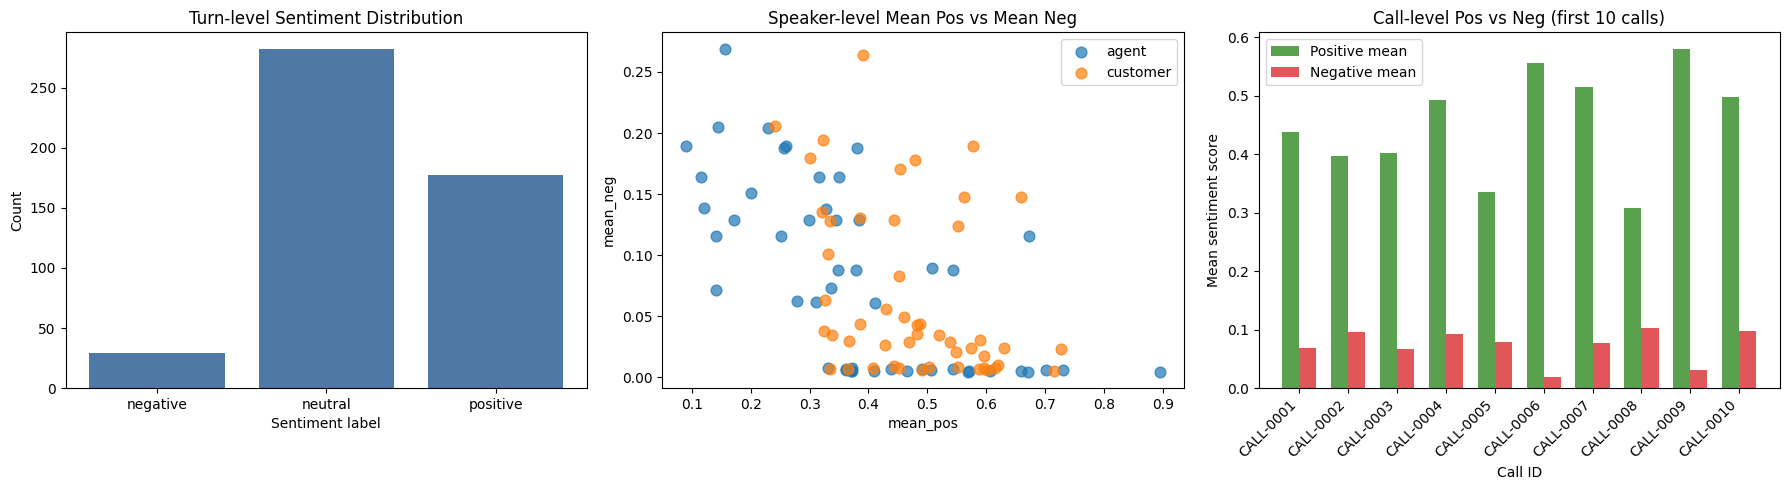

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

sent_dist = out_df["sentiment_50"].value_counts().sort_index()

speakers = list(by_speaker["speaker"].unique())
colors = {"agent":"#1f77b4", "customer":"#ff7f0e"}

top_calls = by_call.sort_values("call_id").head(10)
x = np.arange(len(top_calls))
width = 0.35


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].bar(sent_dist.index, sent_dist.values, color="#4e79a7")
axes[0].set_title("Turn-level Sentiment Distribution")
axes[0].set_xlabel("Sentiment label")
axes[0].set_ylabel("Count")

for spk, grp in by_speaker.groupby("speaker"):
    axes[1].scatter(grp["mean_pos"], grp["mean_neg"],
                    label=spk, alpha=0.7, s=60, color=colors.get(spk,"gray"))
axes[1].set_title("Speaker-level Mean Pos vs Mean Neg")
axes[1].set_xlabel("mean_pos")
axes[1].set_ylabel("mean_neg")
axes[1].legend()

axes[2].bar(x - width/2, top_calls["call_pos_mean"], width, label="Positive mean", color="#59a14f")
axes[2].bar(x + width/2, top_calls["call_neg_mean"], width, label="Negative mean", color="#e15759")
axes[2].set_xticks(x)
axes[2].set_xticklabels(top_calls["call_id"], rotation=45, ha="right")
axes[2].set_xlabel("Call ID")
axes[2].set_ylabel("Mean sentiment score")
axes[2].set_title("Call-level Pos vs Neg (first 10 calls)")
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:

import pandas as pd

out_df.to_csv("/content/call_turn_emotions.csv", index=False)
by_speaker.to_csv("/content/call_summary_by_speaker.csv", index=False)
by_call.to_csv("/content/call_summary_by_call.csv", index=False)

print("Saved CSVs:")
print("- /content/call_turn_emotions.csv")
print("- /content/call_summary_by_speaker.csv")
print("- /content/call_summary_by_call.csv")


Saved CSVs:
- /content/call_turn_emotions.csv
- /content/call_summary_by_speaker.csv
- /content/call_summary_by_call.csv


# **-----------ZERO-SHOT-----------**